`statsmodels` ARIMAX example. See: https://pyflux.readthedocs.io/en/latest/arimax.html



## Setting up our example

In [1]:
# set up Python
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotnine
from plotnine import *
from nested_model_fns import plot_model_quality

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

In [3]:
d_train

,time_tick,z_0,x_0,y,ext_regressors
0,0,0,0,63.273288,"z_0: 0, x_0: 0"
1,1,0,1,80.079317,"z_0: 0, x_0: 1"
2,2,0,0,65.403274,"z_0: 0, x_0: 0"
3,3,0,0,66.425156,"z_0: 0, x_0: 0"
4,4,1,0,80.815189,"z_0: 1, x_0: 0"
...,...,...,...,...,...
975,975,0,0,9.283186,"z_0: 0, x_0: 0"
976,976,0,0,10.085011,"z_0: 0, x_0: 0"
977,977,0,0,12.962078,"z_0: 0, x_0: 0"
978,978,0,1,30.791449,"z_0: 0, x_0: 1"


In [4]:
with open("generating_params.json", "r") as file:
    generating_params = json.load(file)

generating_params

{'b_auto_0': 1.2804125781056719,
 'b_imp_0': 10.4,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

The generating and modeling lags specify translate into ARIMA terms as `p = 2, i = 0`. We take our own  advice from [A Time Series Apologia](https://github.com/WinVector/Examples/blob/main/TS/TS_example.md) and pick `q = p`. So in ARIMAX terms we try fitting a `pdq(2, 0, 2)` system.

In [5]:
model3 = sm.tsa.ARIMA(
    endog=d_train['y'],
    exog=d_train[['z_0', 'x_0']],
    order=[2, 0, 2],
)
fit3 = model3.fit()
print(fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  980
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2438.421
Date:                Fri, 25 Oct 2024   AIC                           4892.843
Time:                        10:13:06   BIC                           4931.943
Sample:                             0   HQIC                          4907.718
                                - 980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.9359      2.254     27.919      0.000      58.518      67.354
z_0            1.4385      0.162      8.867      0.000       1.121       1.757
x_0           16.0379      0.112    142.688      0.0

In [6]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html
d_test["statsmodels ARIMA (external regressors)"] = np.array(
    fit3.predict(
        start=d_train.shape[0],
        end=d_train.shape[0] + d_test.shape[0] - 1,
        exog=d_test[['z_0', 'x_0']],
        )
)

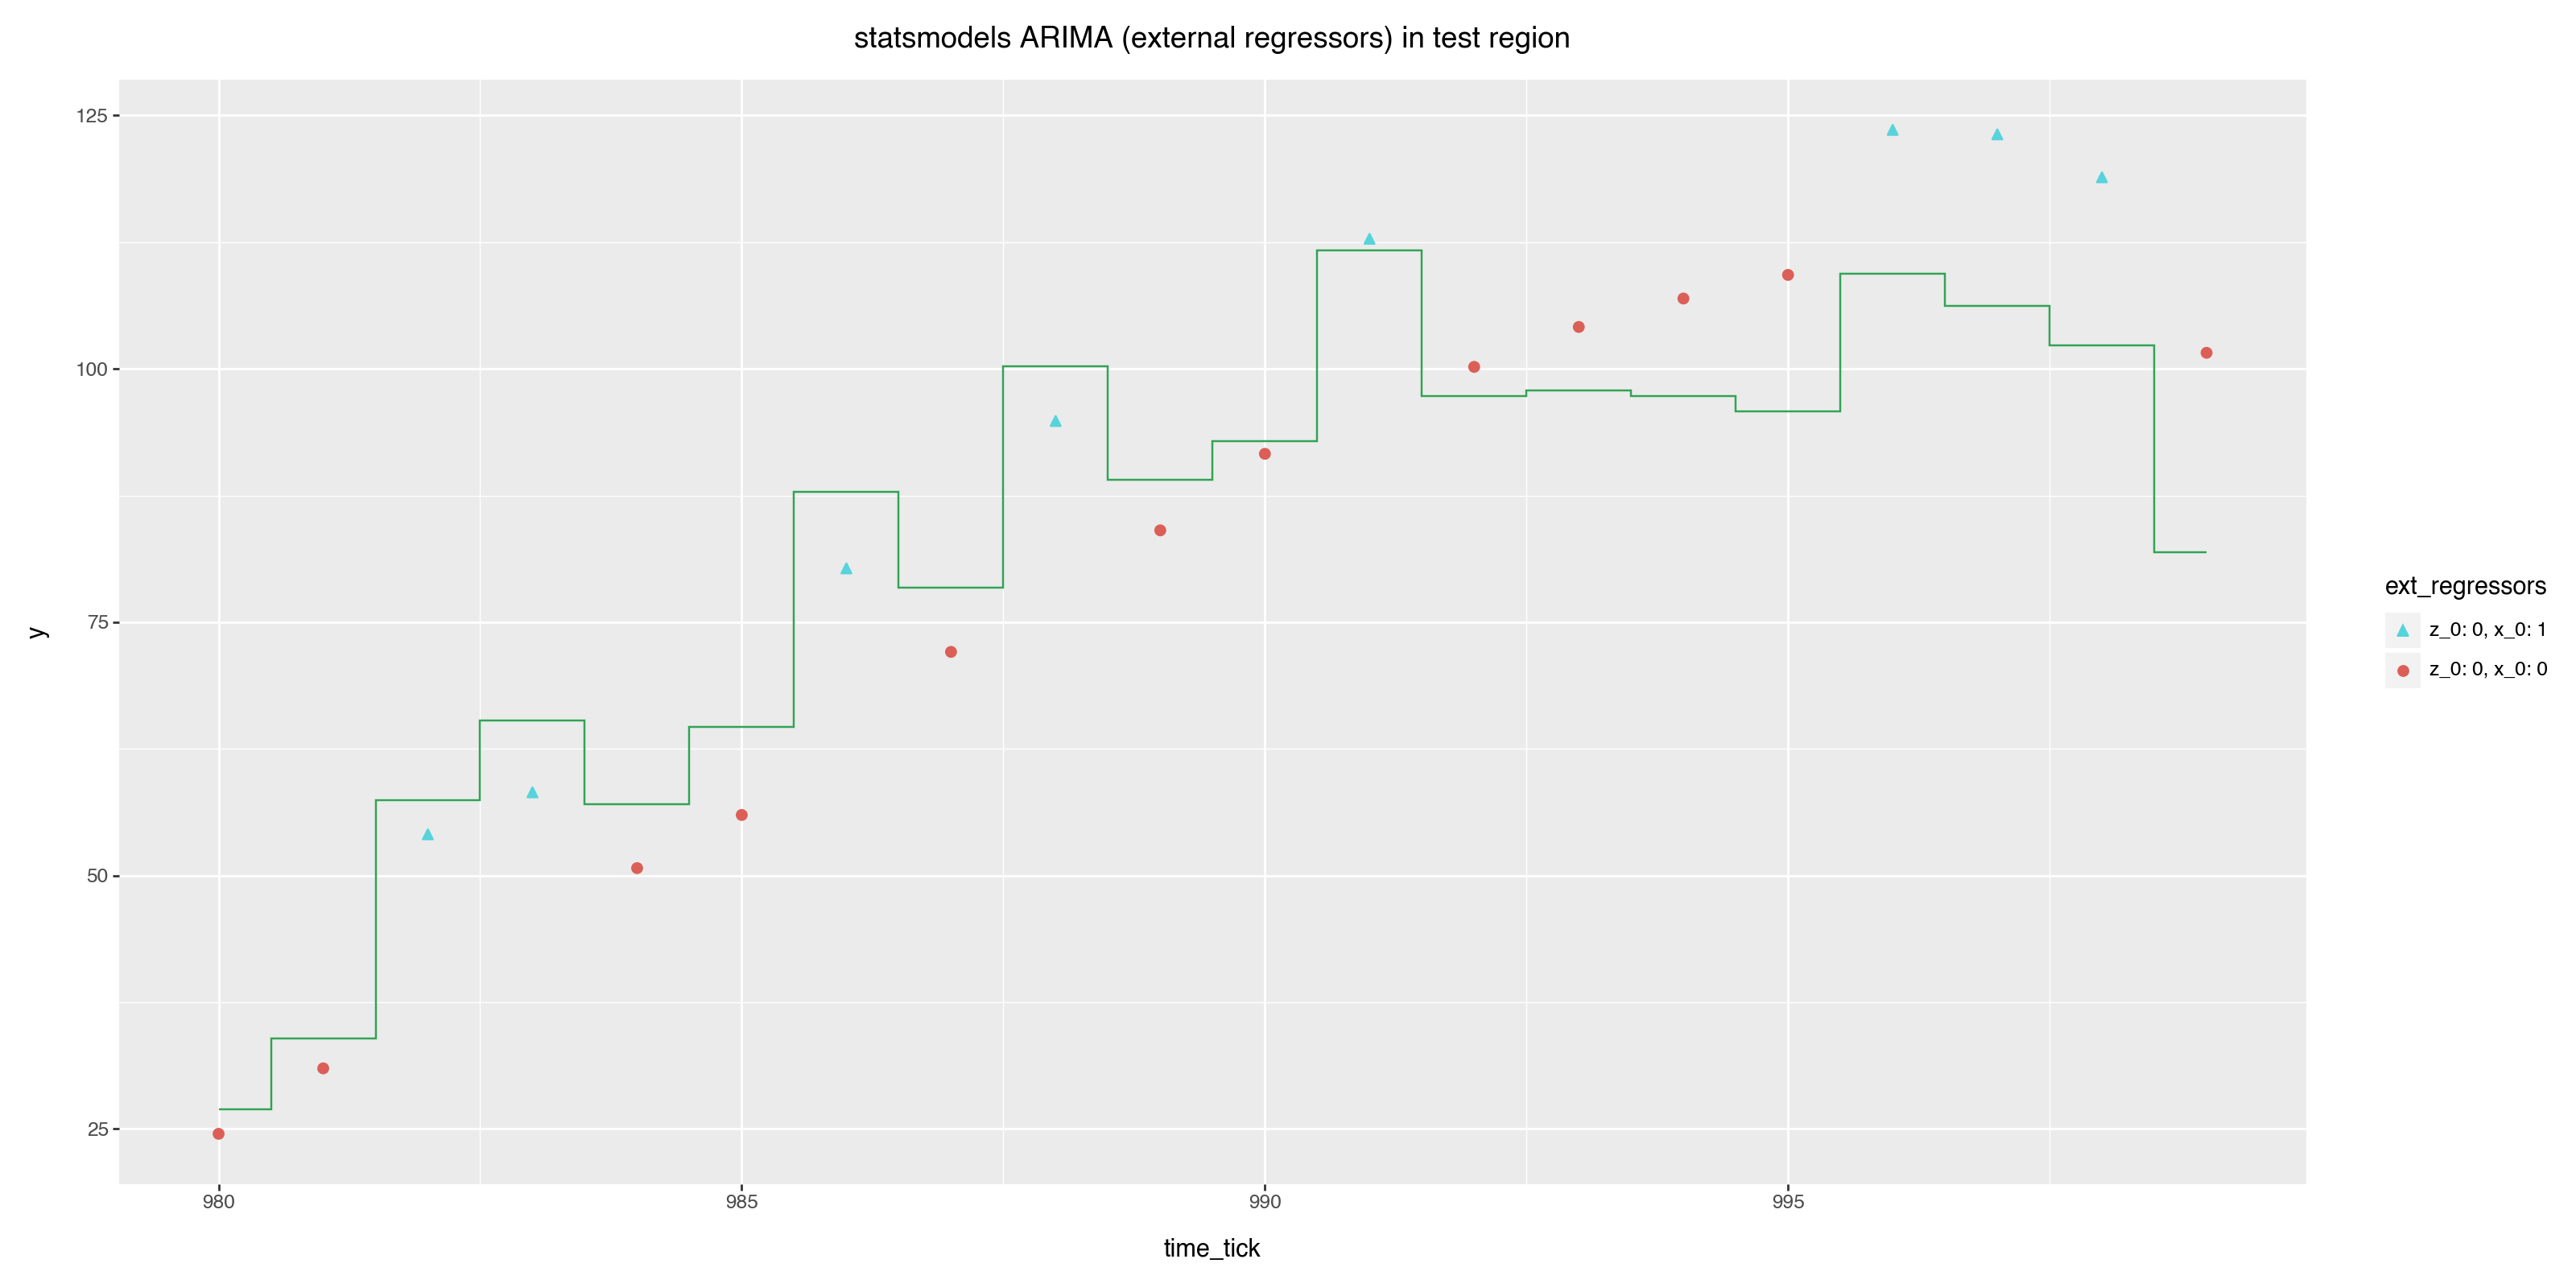

In [7]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(
        aes(y="y", shape="ext_regressors", color="ext_regressors"),
        size=2,
    )
    + geom_step(
        aes(y="statsmodels ARIMA (external regressors)"),
        color="#31a354",
        direction="mid",
    )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("statsmodels ARIMA (external regressors) in test region")
)

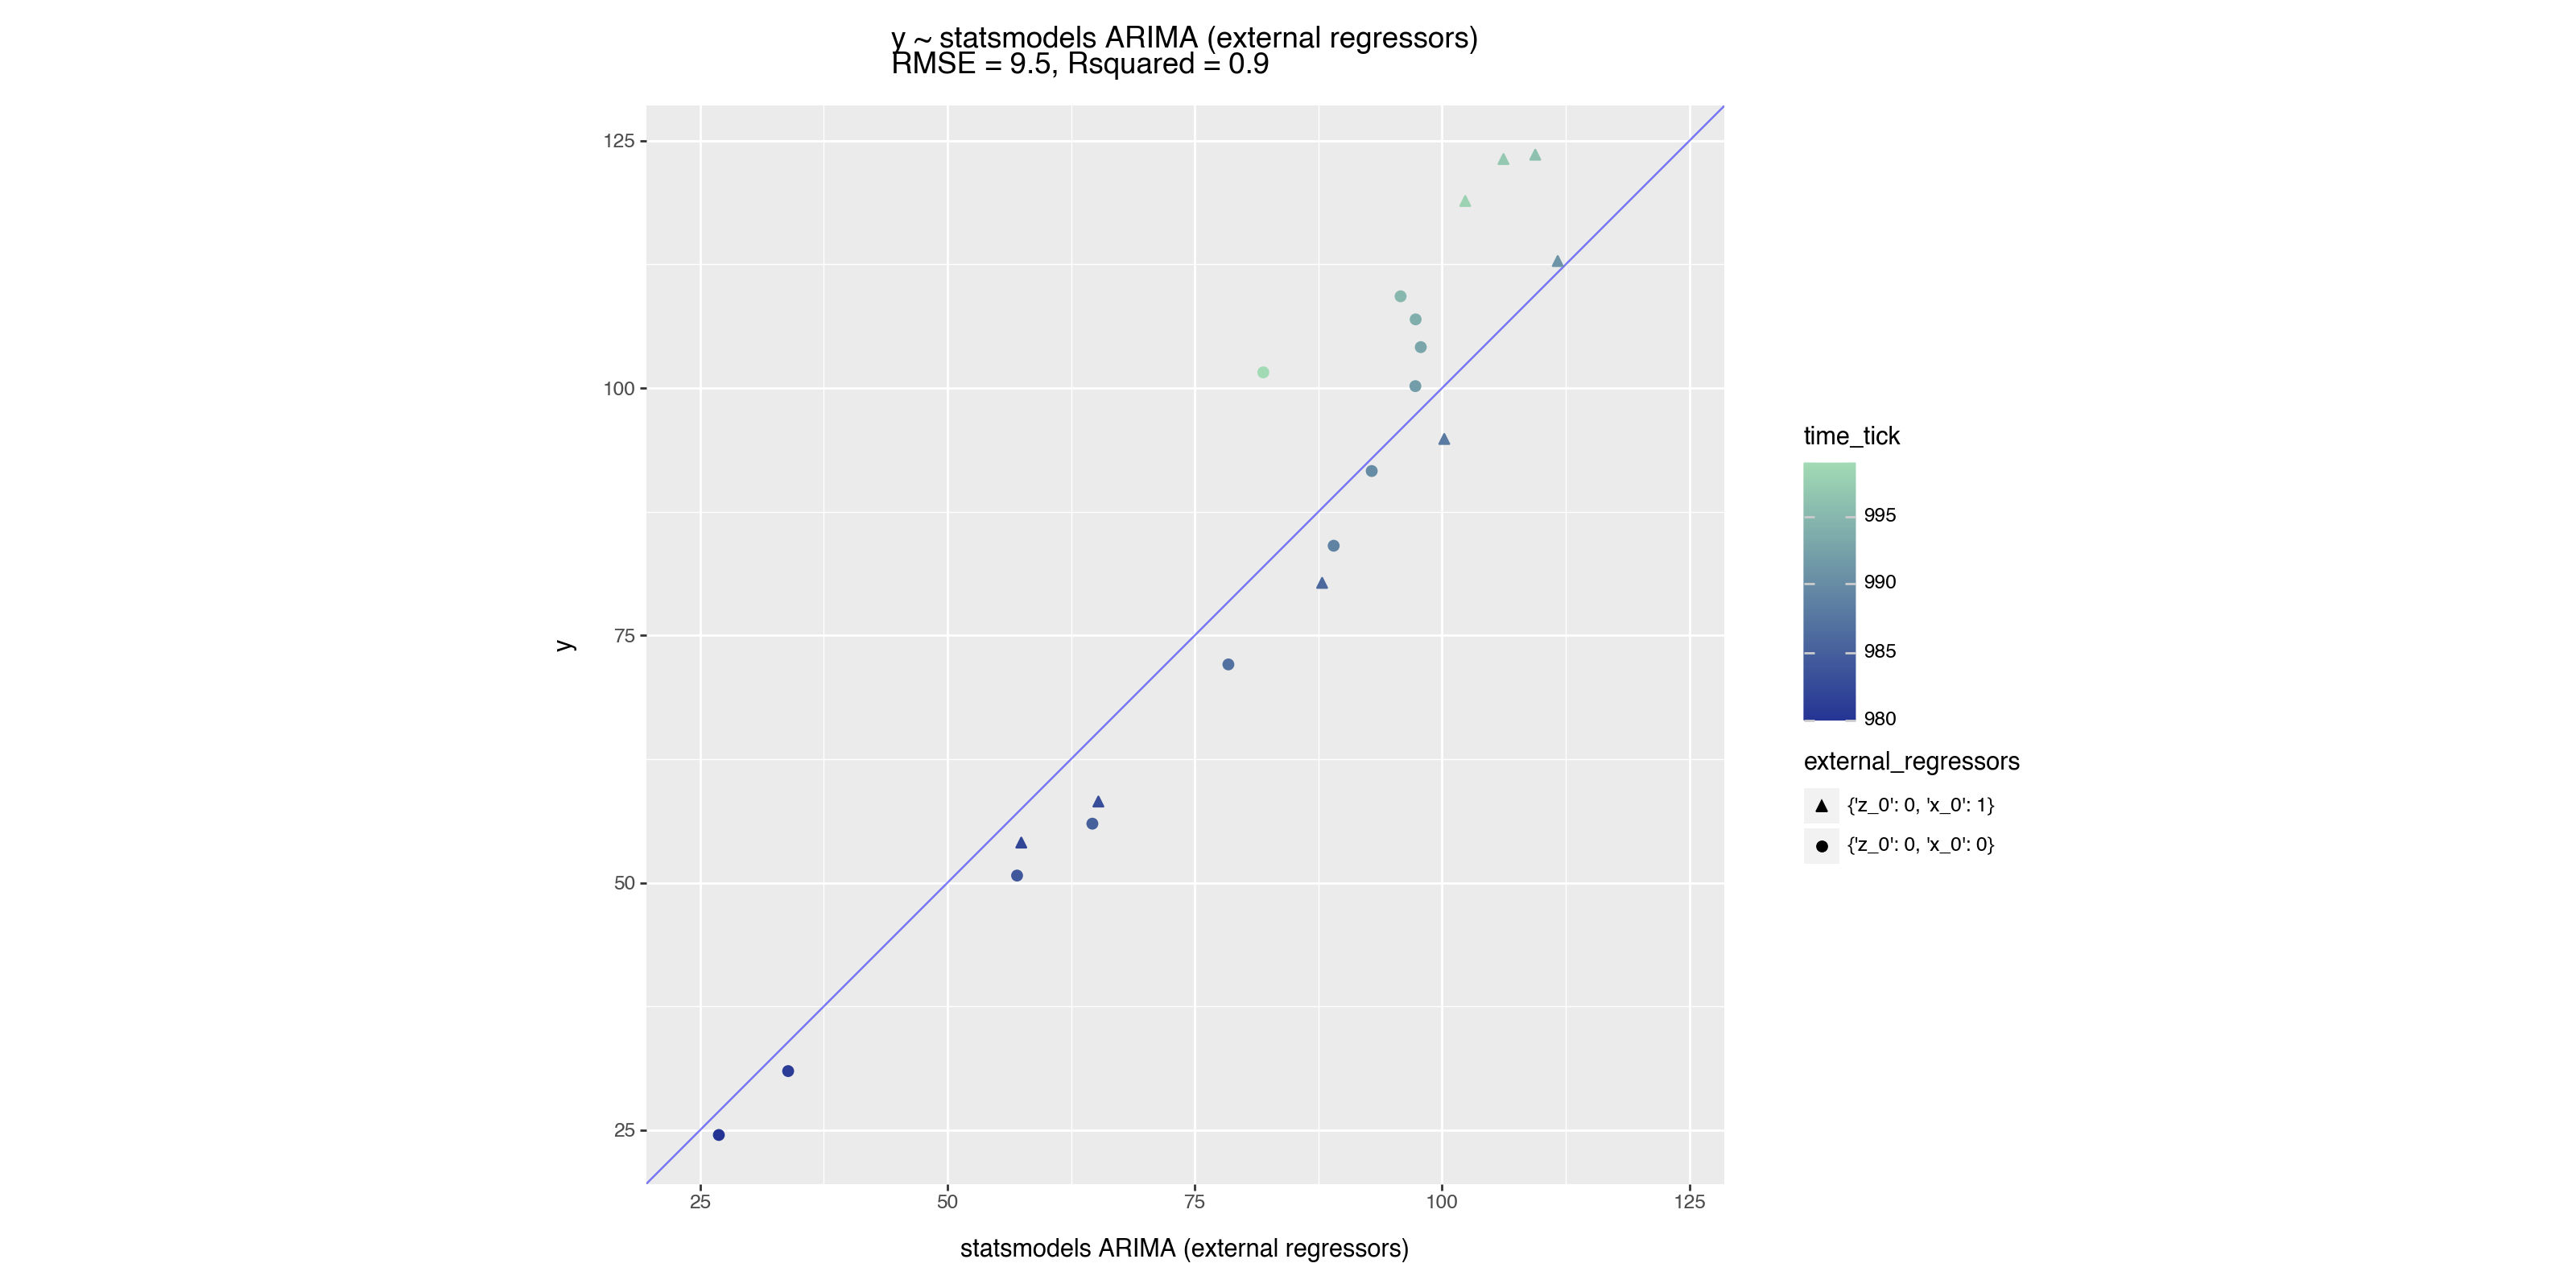

In [8]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["statsmodels ARIMA (external regressors)"]) == False, :
    ],
    result_name="statsmodels ARIMA (external regressors)",
    external_regressors=["z_0", "x_0"],
)